The source code for this project could be found [here](https://github.com/Xianzhiwang1/ml-0451-final-proj). We have a `README.md` file that outlines what our project want to achieve, and roughly how we are going to implement the models and analysis. We also have a separate `.txt` file that gives a dictionary of all the variable names and their actual meaning. Hence, we encourage the reader to also reference that `.txt` file to remember which variable means what.



# Introduction

### What is incorporation? Why does it matter?
Incorporation is the process by which a firm becomes a corporation- a legal entity separate from its ownership. The following are the essential characteristics of a corporation:

- Transferable shares: Shares in the firm, which signify partial ownership in the firm, can be raised, and freely bought and sold.
- Separate legal personhood: The corporation has a separate legal personality from its owners. The death or resignation of an owner does not result in the dissolution of the firm. 
- Limited liability: owners cannot be sued for more than the capital invested by them.
- Separation between management and ownership: the ownership hires specialized managers for day to day operations within the company.


- What is the history of incorporation like

- Some historical context about Russia and descriptions about the Russians system of incorporation
Russia followed the “Concession System of Incorporation”:
- Incorporation was granted on a case-by-case basis
- expensive, time consuming, logistically challenging



## Data
- Where the data comes from

The Russian factory censuses from 1894, 1900 and 1908

- What the data includes

The data is factory level and includes the following information:


- What we're hoping to do with the data
- Some summary statistics


First, let us import some libraries that will become useful down the road. Also, the following snippet will automatically reload the `final_project_code.py` file where we keep our functions.  

In [1]:
%load_ext autoreload
%autoreload 2

In [95]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from final_project_code import FinalProject 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from matplotlib.patches import Patch
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Read in the data
Let us create an instance of the class we defined in `final_project_code.py`, and let us read in the entire data set.

In [96]:
# from sklearn.metrics.pairwise import rbf_kernel
FP = FinalProject()
df = pd.read_csv("./AG_Corp_Prod_DataBase.csv")
Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")

/tmp/ipykernel_182052/3586468696.py:3: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./AG_Corp_Prod_DataBase.csv")
/tmp/ipykernel_182052/3586468696.py:4: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")


First, let's do some data visualization. We are interested in seeing which industry in Late Imperial Russia had high machine power (measured in horsepower) and have high number of workers. We also want to get a sense of the distribution of machine power and number of workers, and visualize them by industry. Hence, let's focus on the picture below. We see that roughly, factory with more machine power tend to also have more workers, and most company cluster at the $2000$ horse power level, and $2500$ workers.   

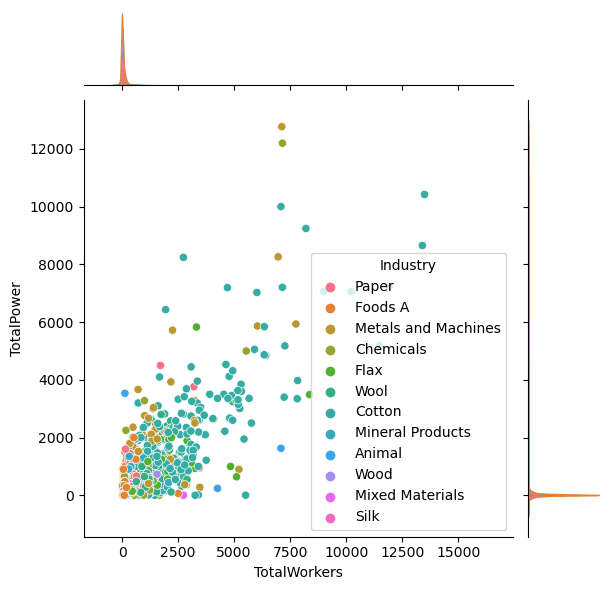

In [97]:
sns.jointplot(data=df, x="TotalWorkers", y = "TotalPower", hue="Industry")

Similarly, here's another plot to visualize the unbalanced nature of the data set. Here, `Form` is the desired label that we want to predict. `Form` taking a value of $1$ means that factory was incorporated, i.e., it was owned by a incorporated firm. If `Form` take the value of $0$, then that factory was not incorporated. In the next plot, instead of `TotalPower`, which stands for Total amount of horse power and `TotalWorkers`, which stands for total number of workers, we use `logPowerperWorker` and `logRevperWorker` as our y-axis and our x-axis. `logPowerperWorker` is obtained by taking the log of $\frac{Power}{Worker}$, and `logRevperWorker` is log of $\frac{Revenue}{Worker}$. And the hue is whether the factory is encorporated or not. Again, we see that the orange dots, which corresponds to $1$, which corresponds to encorporated, is a very small percentage of all the factories. Most factories are not encorporated. Also, we observe that the data points follows a bell-shaped distribution on the two dimensions.  

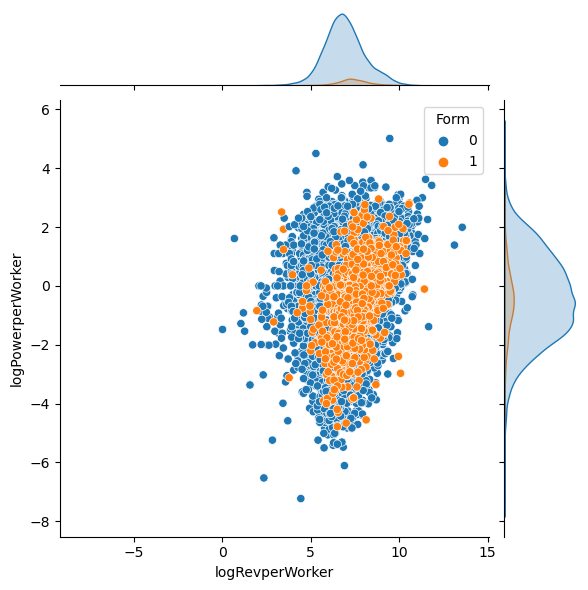

In [98]:
sns.jointplot(data=df, x="logRevperWorker", y="logPowerperWorker", hue = "Form")

# Predicting whether Russian Factories want to incorporate or not

We download the replication data set and put it in the same directory as our project. After we read in the data, we notice that there are $66$ columns, which means potentially we could have around $60$ features for our machine learning model. However, let's start small. Hence, we begin our analysis using a subset of the columns. Also, since in the original data set, there's only a small percentage of factories that are incorporated, which is because of historical reasons in Late Imperial Russia during 1894 to 1908. For the purpose of this machine learning project, we artificially select a subset of the whole data set so that we have equal number of factories owned by incorporated firms and not incorporated firms alike.

### First approach, rebalance the data set by random sampling
We start our analysis by using logistic regression to predict what kind of firms in late Imperial Russia is more likely owned by a corporation. Since our data is not balanced, we use several different approach to this problem and try them one at a time. Luckily for us, classification problem with unbalanced data labels is quite common, so we have many approaches at our disposal. 


In [109]:
not_incorporated = df.loc[df['Form']==0]
print(f"data set dimension of not incorporated: {not_incorporated.shape}")
incorporated = df.loc[df['Form']==1]
print(f"data set dimension of incorporated: {incorporated.shape}")

data set dimension of not incorporated: (37895, 66)
data set dimension of incorporated: (2393, 66)



Let us first get out definitions straight. Unbalanced data refers to those datasets where the target label has an uneven distribution of observations, 
 First, we try to randomly sample the majority data set, which in this case, is when the label equals unincorporated. Then we keep all the data entries of the minority data set, and add in the randomly sampled extract of the majority data set with size equal to the minority data set. Then we perform logistic regression on this new data set. The good news is that our new data set is balanced, and the bad news is that we loose a lot of information by discarding many data entries in the majority data set.  

In [106]:
result = FP.create_balanced_data(df)
train, validate, test = FP.split_data(result)
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

df incorporated have 2393 many rows
after balancing, df not incorporated have 2393 many rows


In [111]:
result["Form"].mean()

0.5

We could also create a under-sampling of the data set where though discarding data points of the majority data set, we achieve a balanced data set, albeit using a small subset of the full data set. Let's store this balanced data set in the variable called `result`. We will mainly use the unbalanced full data set, but `result` data set is quite useful for testing and experimenting during our investigation.  

In [107]:
cols = ['logWorkers', 'logPower'] 
# only run once, convert to numpy
X_train, y_train = FP.make_ready_for_regression(X_train, y_train, cols)
X_validate, y_validate= FP.make_ready_for_regression(X_validate, y_validate, cols)
X_test, y_test= FP.make_ready_for_regression(X_test, y_test, cols)

Let us try the Logistic regression using Newton_Raphson method that we implemented from scratch on this balanced data set. We see that it converged rather quickly, and our score is high for all three groups: training, testing, validation. 

In [108]:
from newton_raphson import Newton_Raphson
NR = Newton_Raphson() 
NR.regress(y = y_train, X = X_train, max_iters = 1e3, tol=1e-15, converged=False)

learning rate is: 0.5
Regularization is: True


/home/xianzhiwang/ml0451/ml-0451-final-proj/posts/final-blog-post/newton_raphson.py:35: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


number of iteration: 10
beta: [[-949.3769919 ]
 [-491.51336087]
 [-514.56704713]]
number of iteration: 20
beta: [[  616.1139379 ]
 [  -77.70969872]
 [-1728.53996285]]
number of iteration: 30
beta: [[  249.78344405]
 [    8.25635669]
 [-1099.30023336]]
number of iteration: 40
beta: [[ 109.88147514]
 [   3.71503689]
 [-483.75986262]]
number of iteration: 50
beta: [[ 1.13087712]
 [ 0.09177811]
 [-4.96515977]]
number of iteration: 60
beta: [[ 0.97942233]
 [ 0.109256  ]
 [-4.31855225]]
number of iteration: 70
beta: [[ 0.97926744]
 [ 0.10927011]
 [-4.31788045]]
number of iteration: 80
beta: [[ 0.97926724]
 [ 0.10927013]
 [-4.31787959]]
number of iteration: 90
beta: [[ 0.97926724]
 [ 0.10927013]
 [-4.31787959]]
number of iteration: 100
beta: [[ 0.97926724]
 [ 0.10927013]
 [-4.31787959]]
Converged with 101 iterations
The beta we end up with is: [[ 0.97926724]
 [ 0.10927013]
 [-4.31787959]]


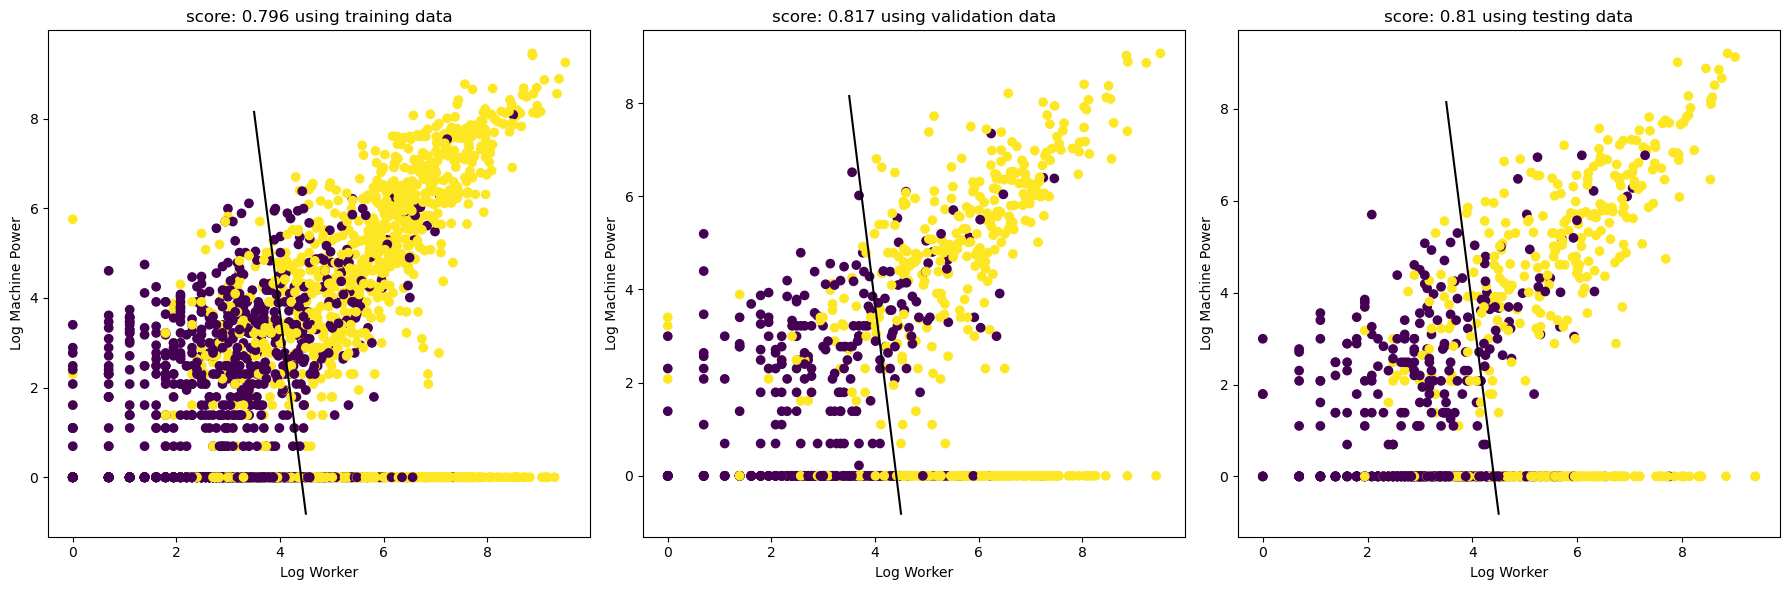

In [114]:
NR.big_plot(X_train, y_train, X_validate, y_validate, X_test, y_test, 18, 6, "Log Worker", "Log Machine Power")

The pictures looks good! The horizontal axis is log of total number of factory workers, and the vertical axis is log of total machine power measured in horse power. We see that factories with more workers and more machine power (on a log scale) are much more likely to incorporate. Since this is log scale, we deduce that factories with significantly more worker and more power tend to incorporate. 

In [13]:
# compression_opts = dict(method='zip', archive_name='artificially_balanced_Rvssian_Factory.csv')
# result.to_csv('artificially_balanced_Rvssian_Factory.zip', index = False, compression=compression_opts)

# Let's do some visualization

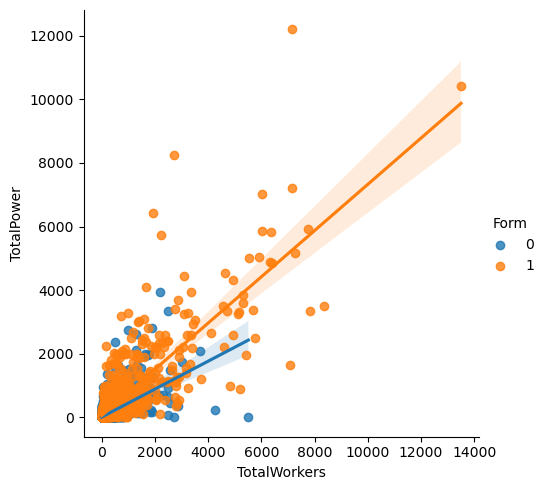

In [117]:
sns.lmplot(data=df_train, x="TotalWorkers", y = "TotalPower", hue="Form")

We see that most factories have around $1000$ to $2000$ workers, and they have around $0$ machine power to $2000$ machine power, measured in horse power. There's also a rough linear trend between total power and total worker, which makes sense. Factories with more power tend to have more workers, and vice versa. 

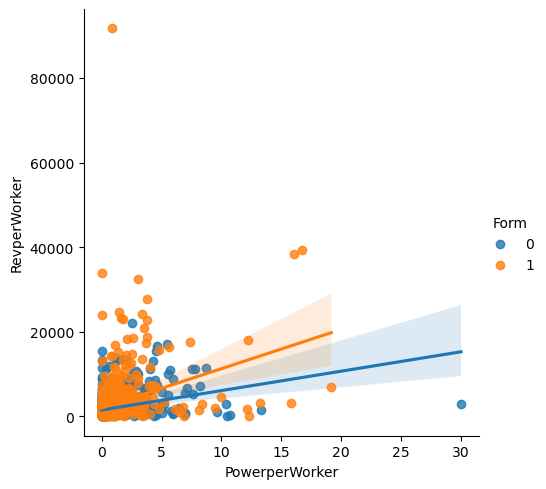

In [81]:
sns.lmplot(data=df_train, x="PowerperWorker", y = "RevperWorker", hue="Form")

Here, we also see that there is a linear trend between Power per worker and Revenue per worker. It seems that factories that are not incorpored (those with `Form == 0`) tend to have more power per worker given the same revenue per worker, compared to their incorporated counterparts.

# First, we try some feature engineering

Whether to incorporate or not is an interesting question for factories and firms in late Imperial Russia. There were many factors that might affect a firm's decision to incorporate or not, including the overall size of the factory, which could be seen in features such as total machine power of the factory and the total number of workers in a factory. Other factors such as the geographical location of the factory (i.e. which region it was located in) could also play a role. Since the decision to incorporate could be affected by many features, we see that some *feature engineering* could be beneficial for our analysis. 

In the basic toolbox of an economist, one is unlikely to find methods of feature engineering, since we believe that economists would rather choose the regressors (features) themselves, becuase regressors are often central to the economic questoin and analysis. However, in this project, we actually going to have a systematic way written in code to select the features, according to which combination of features gives the highest score.

In [140]:
result = FP.create_balanced_data(df)
train, validate, test = FP.split_data(result)
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

df incorporated have 2393 many rows
after balancing, df not incorporated have 2393 many rows


In [141]:
X_train, RegionCoded =   FP.encode_features(X_train, "Region")
X_train['RegionCoded'] = RegionCoded
X_test, RegionCoded =   FP.encode_features(X_test, "Region")
X_test['RegionCoded'] = RegionCoded
X_validate, RegionCoded =   FP.encode_features(X_validate, "Region")
X_validate['RegionCoded'] = RegionCoded

We encode `Region`, which contains strings denoting the region of the factory in question, into numbers.

In [142]:
X_train, IndustryCoded = FP.encode_features(X_train, "Industry")
X_train["IndustryCoded"] = IndustryCoded
X_train = X_train.fillna(0)
# X_train.head(10)

We also encode `Industry` into numbers, so we could run regression on it.

In [143]:
X_train, IndustryFactorCoded = FP.encode_features(X_train, 'IndustryFactor')
X_train["IndustryFactorCoded"] = IndustryFactorCoded

Now, we try all feature combinations and select the one with the highest score according to logistic regression.

In [130]:
FP1 = FinalProject() 
all_qual_cols = ['RegionCoded', 'IndustryCoded', "IndustryFactorCoded"] 

all_quant_cols = [
       'Province', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']
y_train = y_train.reset_index(drop=True)
FP1.feature_combo(all_qual_cols, all_quant_cols, X_train, y_train)    

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We see that it took a very long time to run! Now, let's print out the column conbination with the highest score! 

In [144]:
max(FP1.feature_score_pair, key=FP1.feature_score_pair.get)

('RegionCoded', 'FactoryisCorpin1900', 'NEWDEV')

The highest scoring combination is "RegionCoded", "FactoryisCorpin1900", "NEWDEV", which together gives a logistic regression score of $0.993$.

Another combination that we also considered during the experimenting phase is `RegionCoded`, `RevperGrandWorker`, `logWorkers`, which has a score of $0.808$, which is not bad!

In [145]:
# test for max 
max([-10, 5, 3], key=abs)
print(max(FP1.feature_score_pair.values()))
print(FP1.feature_score_pair[('RegionCoded', 'RevperGrandWorker', 'logWorkers')])
print(FP1.feature_score_pair[("RegionCoded", "FactoryisCorpin1900", "NEWDEV")])

0.9947753396029259
0.8164402647161267
0.9947753396029259


Now, let's use the Newton Raphson method that we implemented from scratch on those three columns!

In [146]:
cols = ["RegionCoded", "FactoryisCorpin1900", "NEWDEV"]
# only run once, convert to numpy
X_train, y_train = FP.make_ready_for_regression(X_train, y_train, cols)
X_validate, y_validate= FP.make_ready_for_regression(X_validate, y_validate, cols)
X_test, y_test= FP.make_ready_for_regression(X_test, y_test, cols)

In [148]:
from newton_raphson import Newton_Raphson
NR1 = Newton_Raphson() 
NR1.regress(y = y_train, X = X_train, max_iters = 1e3, tol=1e-5, converged=False)

/home/xianzhiwang/ml0451/ml-0451-final-proj/posts/final-blog-post/newton_raphson.py:36: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


number of iteration: 10
number of iteration: 20
number of iteration: 30
number of iteration: 40
number of iteration: 50
number of iteration: 60
number of iteration: 70
number of iteration: 80
number of iteration: 90
number of iteration: 100
number of iteration: 110
number of iteration: 120
number of iteration: 130
number of iteration: 140
number of iteration: 150
number of iteration: 160
number of iteration: 170
number of iteration: 180
number of iteration: 190
number of iteration: 200
number of iteration: 210
number of iteration: 220
number of iteration: 230
number of iteration: 240
number of iteration: 250
number of iteration: 260
number of iteration: 270
number of iteration: 280
number of iteration: 290
number of iteration: 300
number of iteration: 310
number of iteration: 320
number of iteration: 330
number of iteration: 340
number of iteration: 350
number of iteration: 360
number of iteration: 370
number of iteration: 380
number of iteration: 390
number of iteration: 400
number of

In [152]:
print(f"validation score: {NR1.score(X_validate,y_validate)}")
print(f"testing score: {NR1.score(X_test,y_test)}")

validation score: 0.9937304075235109
testing score: 0.9979123173277662


Since we are using three features, we are not going to plot it this time. But our score is really high!

# From now on, we will use the full data set, which is unbalanced

In [153]:
train, validate, test = FP.split_data(df)
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

# The Prediction Question:
Can we predict which factory belongs to a incorporated company in Late Imerial Russia, during year 1894 and year 1908, by looking at other variables that are in the data? 

# Data Inspection
Since previously we have artificially selected a subset of our entire Russian factory data set so that we have equal number of factories belonging to incorporated firms and not incorporated firms, we expect that our label has roughly $50 \%$ of $1$'s and $50 \%$ % of $0$'s.

In [124]:
y_train.mean()

0.06044183352639417

In [125]:
df_train.groupby(['Industry'])[['Form']].aggregate([np.mean, len]).round(3)

Form      
                      mean   len
Industry                        
Animal               0.022  2367
Chemicals            0.140  1030
Cotton               0.226  1285
Flax                 0.096   624
Foods A              0.025  5674
Metals and Machines  0.091  3162
Mineral Products     0.046  2567
Mixed Materials      0.043   675
Paper                0.062  1928
Silk                 0.035   491
Wood                 0.039  2556
Wool                 0.056  1813

Hence, it seems that Food industry in Late Imperial Russia had a low incorporation rate, which is around $28.3 \%$. On the other hand, the Cotton industry had a relatively high incorporation rate, around $81.4 \%$.

In [26]:
df_train.groupby(['Industry'])[['TotalPower']].aggregate([np.mean, len]).round(3)

TotalPower     
                          mean  len
Industry                           
Animal                  35.943  216
Chemicals              239.574  185
Cotton                1088.862  345
Flax                   483.345   93
Foods A                 72.742  456
Metals and Machines    321.692  466
Mineral Products        91.953  266
Mixed Materials         81.920   73
Paper                  199.061  247
Silk                    50.485   51
Wood                    62.274  286
Wool                   171.922  187

We see that Cotton industry has the highest mean total power, and Silk industry has the lowest mean total power. We might predict that industry with a higher need for capital might choose to incorporate. 
### After doing feature engineering, we perform a standard regression analysis using some other columns, since we are Economists at heart. We prefer picking those regressors by ourselves...
However, we only want to make 2D plots with two features, so let us only use 2 features this time. We plan to go with Revenue per total worker and log of total worker, which are `RevperGrandWorker`, and `logWorkers`.
### Running some logistic regressions and plotting ROC curves
We start with the standard procedure in Econometrics, which is running regressions. We first perform some regression analysis that is close in spirit to the published paper where this replication data set is coming from, and use ROC curve and confusion matrix to assess our model performance. First, let's get our definition straight. 

* `True Positive Rate = True Positives / (True Positives + False Negatives)`
* `False Positive Rate = False Positives / (False Positives + True Negatives)`

The ROC curve is especially useful when we want to compare directly the curve of several different models. Also, AUC, which stands for the area under the curve can be used to measure how good a model is. 



In [172]:
important_cols = ['RegionCoded', 'RevperGrandWorker', 'logWorkers']
high_scoring_cols = ["RegionCoded", "FactoryisCorpin1900", "NEWDEV"]
# X_train = X_train.drop(["Industry"], axis=1)
# X_train = X_train.drop(["Region"], axis=1)
# X_train.drop(["FoundingYear", "OntheSide", "TaxedActivity", "PSZLastYear", "PSZ1908"], axis=1)
X_train = X_train.fillna(0)
y_train.reset_index(drop=True)
# cols = ["FactoryisCorpin1900", "NEWDEV"]
cols = ['RevperGrandWorker', 'logWorkers']
# fit a model
LR = LogisticRegression(solver="newton-cg") # Newton's Method
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

0.9472943902035413

In [173]:
# ROC curve, receiver operating characteristic
# TPR true positive rate
# FPR false positive rate

# predict the probability
probability = LR.predict_proba(X_test[cols])

In [174]:
# get the probabilities for the positive outcome
proba_positive = probability[:,1]

In [175]:
# get a no-skill prediction that always predict the majority class
proba_no_skill = [0 for _ in range(len(y_test))]

In [176]:
# compute the scores
auc_no_skill = roc_auc_score(y_test, proba_no_skill) 
auc_LR = roc_auc_score(y_test, proba_positive)
print(f"Always predict zero, which is not incorporate. ROC AUC = {auc_no_skill}")
print(f"Use Logistic Regression. ROC AUC = {auc_LR}")
# fpr, tpr, thresholds = roc_curve(y_train, scores, pos_label=2)

Always predict zero, which is not incorporate. ROC AUC = 0.5
Use Logistic Regression. ROC AUC = 0.8593987534204925


[[0.99235837 0.00764163]
 [0.75641026 0.24358974]]


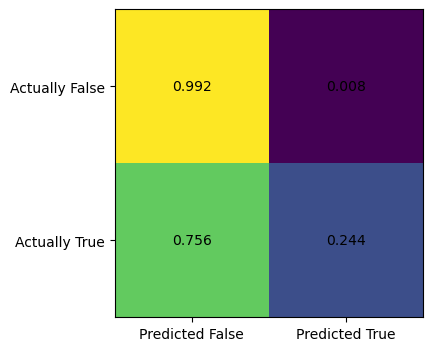

In [177]:
print(confusion_matrix(y_test, LR.predict(X_test[cols]), normalize="true"))
FP.print_confusion_matrix(LR, X_test[cols], y_test)

We see that there is big discrepency between the upper left corner and the lower right corner of the confusion matrix. The upper right corner is the false positive rate, which is extremely low, at $0.008$. By contrast, the false negative rate, which is at the lower left corner, is very high, at $0.756$. This means the logistic regression model implementing Newton's method is very biased towards preducing false negative results, i.e., predicting a factory is not incorporated, while it is actually incorporated. This is quite consistant with our intuition, since most factories in that historical period is not incorporated, so our model would get a high score by predicting any given factory as not incorporated. Below, we plot the ROC curve.

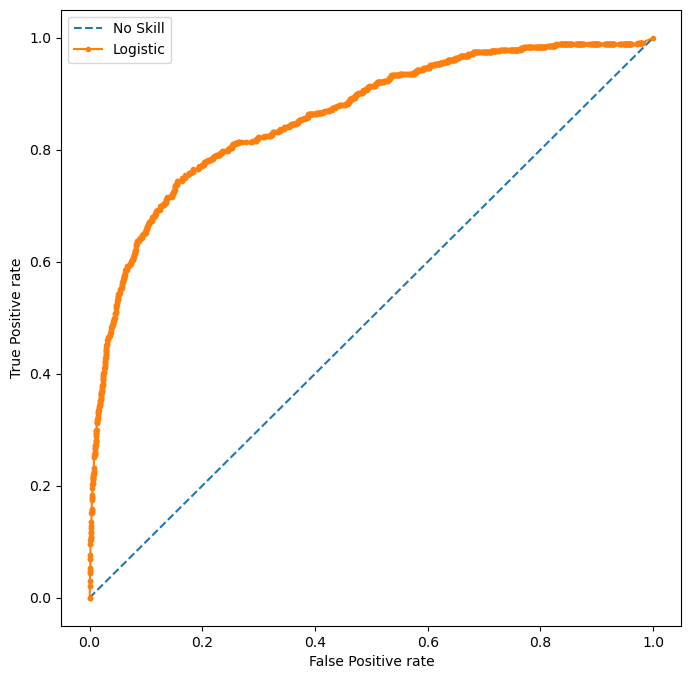

In [178]:
# compute roc curves
fpr_no_skill, tpr_no_skil, _ = roc_curve(y_test, proba_no_skill)
fpr_LR, tpr_LR, _ = roc_curve(y_test, proba_positive)
# plot the roc curve for the model
plt.plot(fpr_no_skill, tpr_no_skil, linestyle="--", label="No Skill")
plt.plot(fpr_LR, tpr_LR, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
# show the legend
plt.legend()
# show the plot
plt.show()



At least, logistic regression is doing much better than a no-skill predictor, which always predict not incorporate in this case.

We are interested in seeing the coefficients for the regressors in our logistic regression. We see that the coefficient for revenue per worker grand total `RevperGrandWorker` is $0.000056$, and the coefficient for `logWorkers`, the log of the number of workers is $1.048$. In the cells below, we are also interested in visualizing the decision region of our model. We see that the desion boundary is linear, and since our data are all relatively clustered together, the picture does not really show that our model is doing a fantastic job. It is quite hard to guess how many data points are in the correct region because of it's quite dense. 

In [161]:
pd.DataFrame({
    "column": X_train[cols].columns,
    "coefficient": LR.coef_.ravel()
})

,column,coefficient
0,RevperGrandWorker,0.000039
1,logWorkers,1.139265


We see that Revenue per total (grand) worker has a very small coefficient, while log workers has a much larger coefficent compared to Revenue per total worker.

In [187]:
print(type(X_test[cols]))
print(X_test[cols].head(2))
# X_test[col].head(50)

<class 'pandas.core.frame.DataFrame'>
       RevperGrandWorker  logWorkers
7737           449.42606    5.648974
31436         2729.16670    3.178054


False


/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


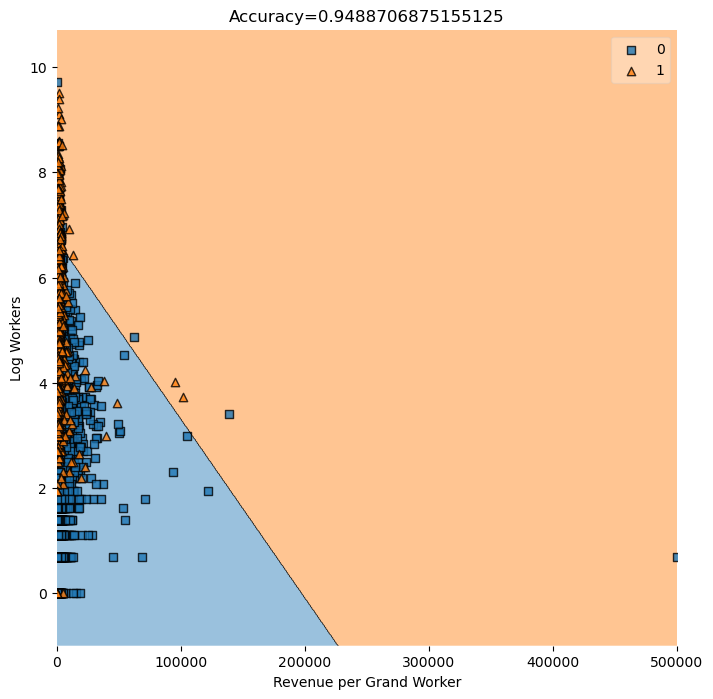

In [186]:
plt.rcParams["figure.figsize"]=(8,8)
print(isinstance(X_train[cols], np.ndarray))
# need to write up the function that make a visual representation
value=1.5
width=0.75
plot_decision_regions(X_test[cols].to_numpy(), y_test.to_numpy(), clf=LR
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = LR.predict(X_test[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_test).mean()}",
                      xlabel="Revenue per Grand Worker",
                      ylabel="Log Workers")

We see that factories with much more worker and much more revenue per worker is predicted to incorporate by logistic regression, which fits our intuition. 

# Now we try Polynomial Features

Since we are at it, let us pick two other columns, `TotalWorkers`, which is total number of workers, and `TotalPower`, which is total machine power of a factory, and run more regressions.
# Use cross validation
Now, we are unsure if using polynomial features would give our model more predictive power. One way to find out is by trying different degrees of polynomials and score them using cross validation. The idea behind cross validation is as follows: we divide the data into little chunks, and in each regression, one of the chunks is used as validation data set, and all other chunks are used as training data set. Each little chunk takes turn to be used for validation, hence the name cross validation. We could take the average of all those scores and use this average to compare models with different degrees. 

In [194]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import warnings

In [195]:
col=['TotalWorkers','TotalPower']
def poly_LR(deg):
    return Pipeline([("poly", PolynomialFeatures(degree=deg)),
                     ("LR", LogisticRegression(penalty="none", max_iter=int(1e3)))])

plr = poly_LR(deg = 2)

Let us start with using degree $2$ polynomial feature, which is like adding quadratic terms. Also, let us suppress the warning messages.

In [196]:
with warnings.catch_warnings():
    warnings.simplefilter("always")
    warnings.filterwarnings("ignore")
    cv_scores = cross_val_score(plr, X_train[cols], y_train, cv=5)
    print(cv_scores)

[0.93960703 0.93940021 0.93959454 0.9391808  0.93959454]


Hey, our scores are pretty high!

In [197]:
print(cv_scores.mean())

0.9394754237799386


Hence, this is telling us that for the features we selected, polynomial logistic regression has roughly the same predictive power as simply guessing whether a factory is belonging to a corporation or not. Degree zero corresponds to the baseline model, and degree 1 corresponds to simple logistic regression without a polynomial feature map.

In the above code snippets, we defined a model using degree 2 polynomial features, did cross validation by dividing data into 5 chunks, and then we take the mean to get the final score. Now, we put this into a function with a for loop, that will lop through each number of polynomial degree and give us a score. 

In [198]:

with warnings.catch_warnings():
    warnings.simplefilter("always")
    warnings.filterwarnings("ignore")
    FP.polynomial_degree_validation(X_train[cols], y_train, 4, 5)

Polynomial degree = 0, score = 0.94
Polynomial degree = 1, score = 0.947
Polynomial degree = 2, score = 0.939
Polynomial degree = 3, score = 0.94


Hence, we see that degree one has the highest score, meaning that we just need simple logistic regression in this case. Since this score comes from cross validation, we could rely on the accuracy of this score to some extent. Now, we use simple logistic regression with no polynomial features to `fit` our training data once again, and we test on the testing data. 

In [200]:
with warnings.catch_warnings():
    warnings.simplefilter("always")
    warnings.filterwarnings("ignore")
    plr = poly_LR(1)
    plr.fit(X_train[cols], y_train)
    print(plr.score(X_train[cols], y_train))
    print(plr.score(X_test[cols], y_test).round(4))

0.9472116498427933
0.9489


We get a score of $0.949$, which is not bad! Also, let us print out the classification report for our model. Again, our precision score is not bad!

In [201]:
y_predict = plr.predict(X_test[cols])
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7590
           1       0.66      0.24      0.36       468

    accuracy                           0.95      8058
   macro avg       0.81      0.62      0.66      8058
weighted avg       0.94      0.95      0.94      8058



In [202]:
print(confusion_matrix(y_test, y_predict))
print(confusion_matrix(y_test, y_predict, normalize = "true"))

[[7532   58]
 [ 354  114]]
[[0.99235837 0.00764163]
 [0.75641026 0.24358974]]


Recall that the confusion matrix is organized as follows, so we could read the data right off the matrix.
$$ 
\begin{matrix}
\text{True Positive} & \text{False Positive} \\
\text{False Negative} & \text{True Negative} \\
\end{matrix}
$$
In our case, we have $7532$ true positives and $114$ true negatives for our test data, and $58$ false positives and $354$ false negatives. This is not evenly distributed, our model does give more false negatives than false positives, not the other way round. Hence, our model's prediction is slightly biased. Also, by specifying `normalize = "true"`, we could get the True Positive Rate (TPR), False Positive Rate (FPR), and so on. Feel free to check the definition given above earlier. 

Now, let's find out the mean machine power per worker for our testing set `X_test`, which is $0.6$. Now, we would like to filter our test data `X_test` and only keep the entries that have more than average power per worker. Then we print out our compusion matrix again just for those entries with more than average machine power per worker. We are interested to see if our model is biased or not, in the sense that it might give more False Positives than False Negatives, or the other way round.

In [203]:
X_test["PowerperWorker"].mean()

0.7737687122972201

In [204]:
ix = X_test["PowerperWorker"] > 0.63483127
print("Factories with more power per worker than average")
print(f"The percentage our prediction is correct: {(y_test[ix] == y_predict[ix]).mean()}")
confusion_matrix(y_test[ix], y_predict[ix])

Factories with more power per worker than average
The percentage our prediction is correct: 0.9391592920353983


array([[1662,   13],
       [  97,   36]])

We see that our model has predicted false negative for $97$ cases, and false positive for $13$ cases for factories with more power per worker than average. Hence, in this case, our model is slightly biased towards false negative, predicting the factory is not incorporated (negative) when the factory is actually incorporated (positive). This makes economic sense, since we have selected only factories with above average machine power, and since factories with more machine power stood to gain more investment and capital if they incorporate, they were more likely to incorporate than average, so our model, which is trained on all the entries in `X_train`, has predicted more false negatives for factories with more power, and this fits our economic intuition.

In [205]:

ix = X_test["PowerperWorker"] < 0.63483127
print("Factories with less power per worker than average")
print(f"The percentage our prediction matches the actual label: {(y_test[ix] == y_predict[ix]).mean()}")
print(confusion_matrix(y_test[ix], y_predict[ix]))
print(confusion_matrix(y_test[ix], y_predict[ix], normalize="true"))

Factories with less power per worker than average
The percentage our prediction matches the actual label: 0.95168
[[5870   45]
 [ 257   78]]
[[0.99239222 0.00760778]
 [0.76716418 0.23283582]]


We do the exact same thing for restricting our data set to only factories with less machine power per worker than average. The situation is exactly flipped, since we have more false positive than false negative. Our model tend to predict incorporated when the factory was not incorporated. This is consistent with our findings earlier, since we are in the exact flip case, where we restrict to factories with less machine power, and those are factories that potentially benefit less from the access to more captial and credit brought by incorporation, since they are not perticularly machine intensive. Hence, they had a slightly lower probability to incorporate. 

# Logistic regression implementing Newton's Method

In [225]:
cols = ['logWorkers', 'logPower']
cols = ["FactoryisCorpin1900", "NEWDEV"]
cols = ['PowerperWorker', 'RevperGrandWorker']
cols=['TotalWorkers','TotalPower']

In [226]:
train, validate, test = FP.split_data(df)
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

In [227]:
X_train, y_train = FP.make_ready_for_regression(X_train, y_train, cols)
X_validate, y_validate= FP.make_ready_for_regression(X_validate, y_validate, cols)
X_test, y_test= FP.make_ready_for_regression(X_test, y_test, cols)
print(y_train.shape)

(24172, 1)


# Moment of Truth

In [ ]:
from newton_raphson import Newton_Raphson 
NR3 = Newton_Raphson() 
NR3.regress(X_train,y_train,1e3,1e-3,False)

In [88]:
Reg = LogisticRegression(tol = 0.01, solver='newton-cg').fit(X_train[cols], y_train)

In [89]:
print(f"the coefficients are: {Reg.coef_}")
print(f"the intercept is: {Reg.intercept_}")

the coefficients are: [[1.03807274 0.13950588]]
the intercept is: [-4.60913112]


In [90]:
print(X_test[cols].to_numpy().shape)
print(NR.predict(X_test[cols].to_numpy()).shape)

(958, 2)
(958, 1)


In [91]:
y_train = y_train.reshape(-1)
plot_decision_regions(X_train[cols].to_numpy(), y_train, clf=NR
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = NR.predict(X_train[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_train).mean()}",
                      xlabel="Feature 1",
                      ylabel="Feature 2")

AttributeError: 'Series' object has no attribute 'reshape'

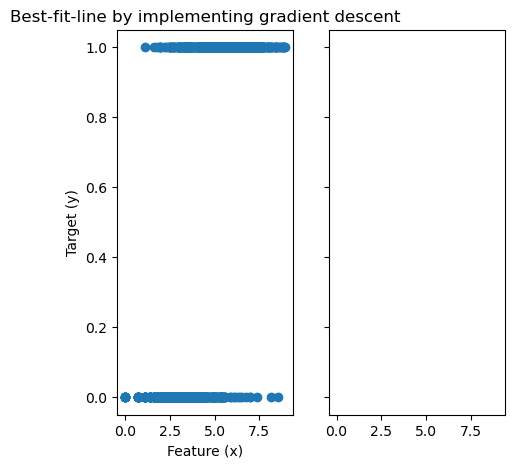

In [92]:
x = X_test[cols].to_numpy()[:,0]
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_test[cols].to_numpy()[:,0], y_test.to_numpy())
# axarr[0].plot(x, x@FP.beta, color = "black")

# Analytic 
# LR2 = LinearRegression()
# X_ = LR2.pad(x)
# LR2.fit_analytic(X_,y)

# axarr[1].scatter(x,y)
# axarr[1].plot(x, X_@LR2.w, color = "black")

labs = axarr[0].set(title="Best-fit-line by implementing gradient descent", xlabel = "Feature (x)", ylabel = "Target (y)")


In [93]:
print(isinstance(X_test[cols], np.ndarray))
X_test = X_test.fillna(0)

False


In [94]:
value=1.5
width=0.75
plot_decision_regions(X_train[cols].to_numpy(), y_train, clf=Reg
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = Reg.predict(X_train[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_train).mean()}",
                      xlabel="Feature 1",
                      ylabel="Feature 2")

ValueError: y must be a NumPy array. Found <class 'pandas.core.series.Series'>

# Using our own implementation of Newton's method logistic regression from scratch

In [52]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from matplotlib.patches import Patch
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [53]:
from final_project_code import FinalProject 
from newton_raphson import Newton_Raphson
from final_plot import plot_stuff

In [54]:
# from sklearn.metrics.pairwise import rbf_kernel
FP = FinalProject()
df = pd.read_csv("./AG_Corp_Prod_DataBase.csv")

/tmp/ipykernel_182052/3545232409.py:3: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./AG_Corp_Prod_DataBase.csv")


In [55]:
df = FP.create_balanced_data(df)
# df = df.sample(n=10000, replace=False)
train, validate, test = FP.split_data(df)

df incorporated have 2393 many rows
after balancing, df not incorporated have 2393 many rows


In [56]:
cols=['TotalWorkers','TotalPower']
# RegionCoded is not generated here
cols = ["RegionCoded", "FactoryisCorpin1900", "NEWDEV"]
cols = cols[1:]

In [57]:
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

In [58]:
cols = ['PowerperWorker', 'RevperGrandWorker']
cols = ['logWorkers', 'logPower'] 

In [59]:
# only run once, convert to numpy
X_train, y_train = FP.make_ready_for_regression(X_train, y_train, cols)
X_validate, y_validate= FP.make_ready_for_regression(X_validate, y_validate, cols)
X_test, y_test= FP.make_ready_for_regression(X_test, y_test, cols)

In [60]:
from newton_raphson import Newton_Raphson
NR = Newton_Raphson() 
NR.regress(y = y_train, X = X_train, max_iters = 1e3, tol=1e-15, converged=False)

learning rate is: 0.5
Regularization is: True


/home/xianzhiwang/ml0451/ml-0451-final-proj/posts/final-blog-post/newton_raphson.py:35: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


number of iteration: 10
beta: [[2468.33122567]
 [1351.26460957]
 [-376.27453233]]
number of iteration: 20
beta: [[ 196.98766101]
 [  12.69169584]
 [-878.31183364]]
number of iteration: 30
beta: [[  72.3325303 ]
 [   4.6256566 ]
 [-319.73349431]]
number of iteration: 40
beta: [[ 10.03168898]
 [  0.55150783]
 [-44.82905515]]
number of iteration: 50
beta: [[ 1.02912765]
 [ 0.13883424]
 [-4.56914719]]
number of iteration: 60
beta: [[ 1.03981904]
 [ 0.13939213]
 [-4.61613743]]
number of iteration: 70
beta: [[ 1.03983338]
 [ 0.13939279]
 [-4.61620088]]
number of iteration: 80
beta: [[ 1.0398334 ]
 [ 0.13939279]
 [-4.61620097]]
number of iteration: 90
beta: [[ 1.0398334 ]
 [ 0.13939279]
 [-4.61620097]]
Converged with 97 iterations
The beta we end up with is: [[ 1.0398334 ]
 [ 0.13939279]
 [-4.61620097]]


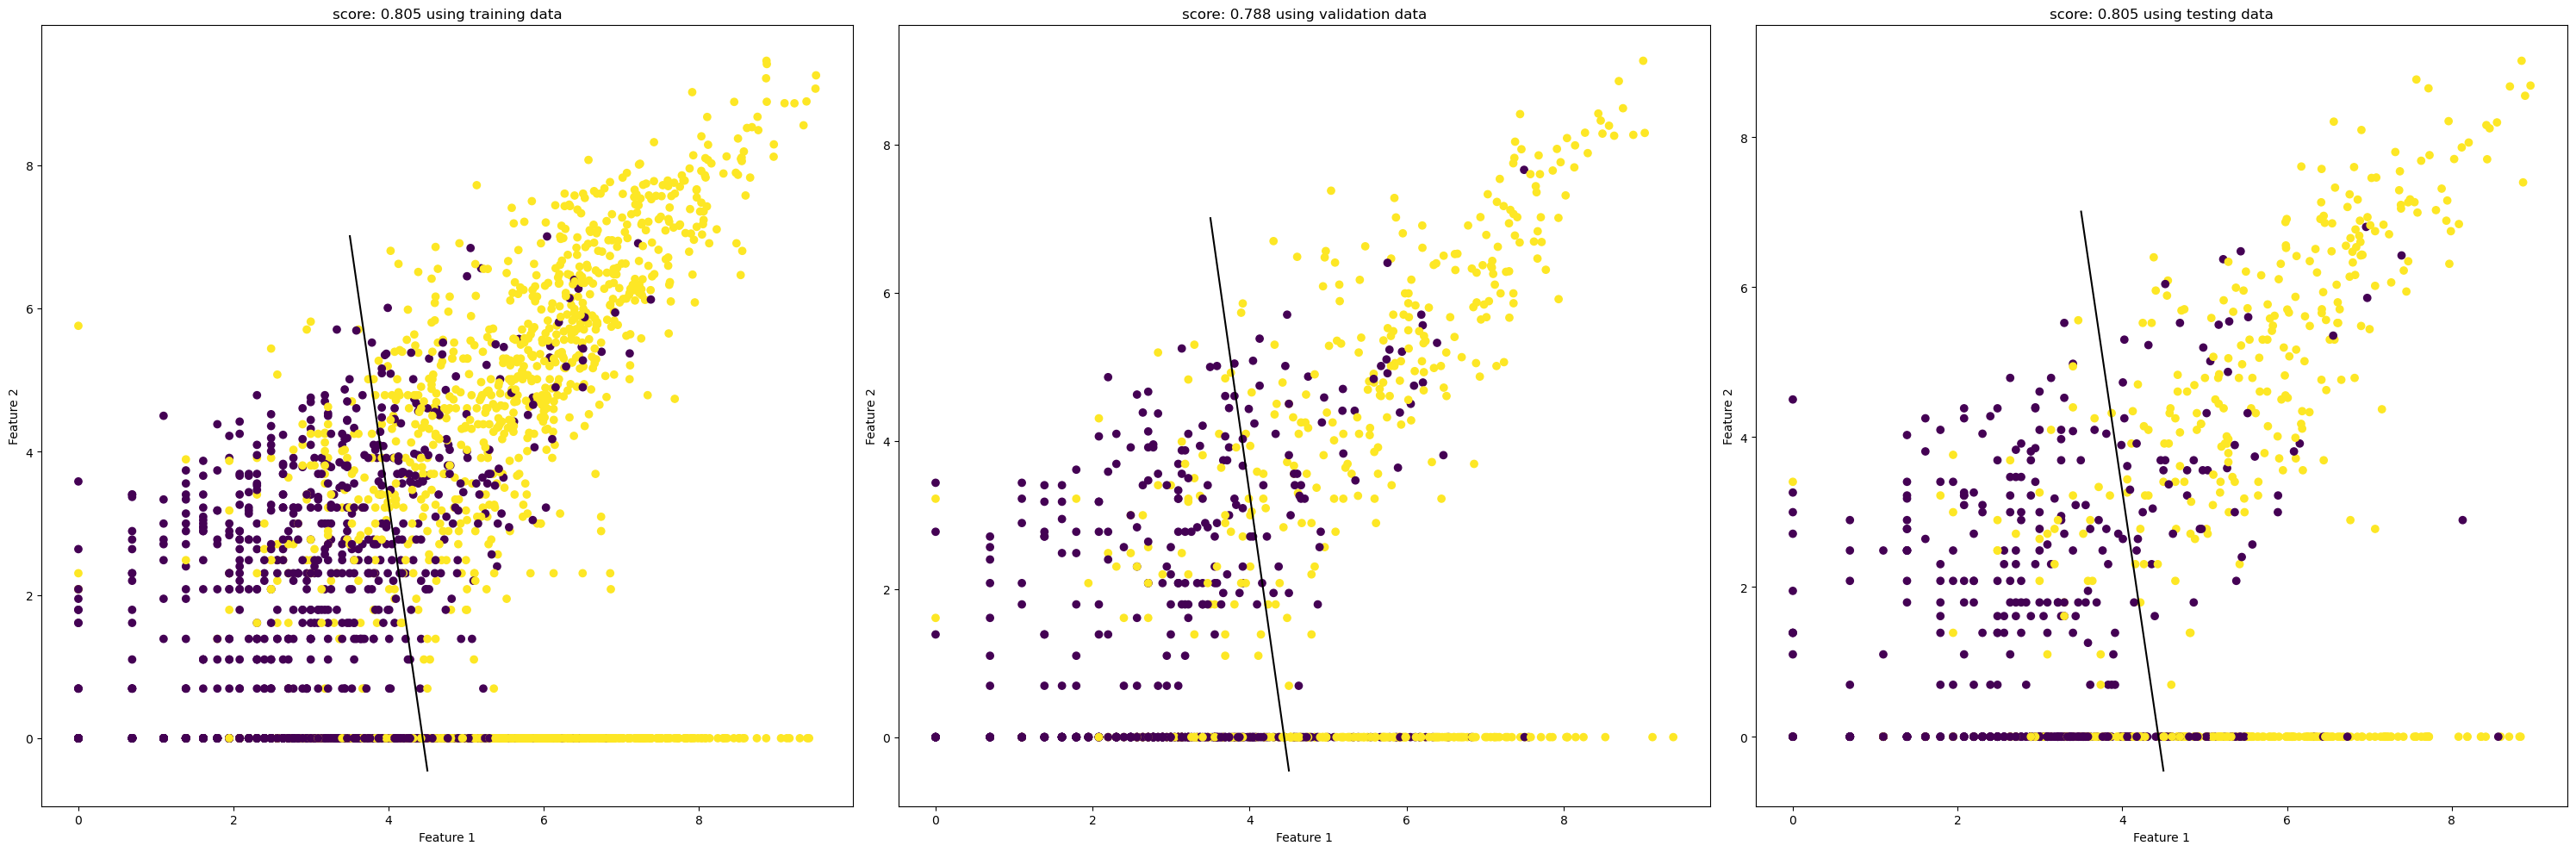

In [61]:
NR.big_plot(X_train, y_train, X_validate, y_validate, X_test, y_test, 30, 10)

the weight beta is: [[ 1.0398334 ]
 [ 0.13939279]
 [-4.61620097]]
0.8049460118425635
0.8048016701461378
0.7878787878787878


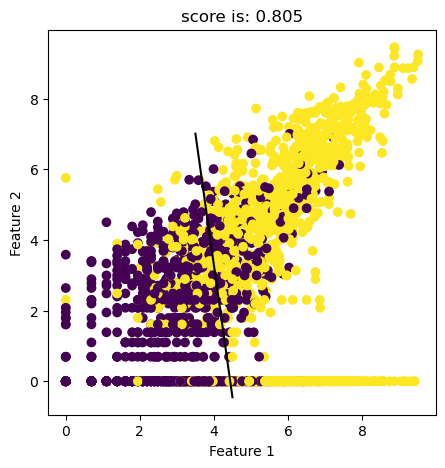

In [62]:
NR.bare_bone_plot(X_train, y_train, 5,5)
print(NR.score(X_train,y_train))
print(NR.score(X_test,y_test))
print(NR.score(X_validate,y_validate))

In [63]:
# from final_plot import plot_stuff
# PS = plot_stuff()
cols = ['logWorkers', 'logPower'] 

In [64]:
LR = LogisticRegression(solver="newton-cg")
LR.fit(X_train, y_train)
LR.coef_

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1.03807464, 0.13950608]])

In [65]:
LRscoreTest = LR.score(X_test, y_test)
print(LRscoreTest)
LRscoreTrain= LR.score(X_train, y_train)
print(LRscoreTrain)

0.8048016701461378
0.8049460118425635


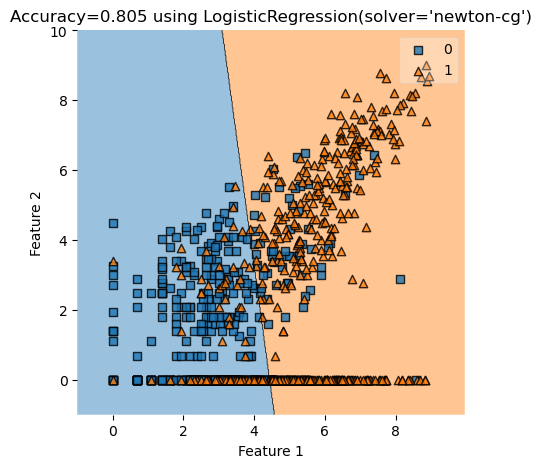

In [66]:
y_test= y_test.reshape(-1)
NR.simple_plot(LR, X_test, y_test, 5, 5)